<a href="https://colab.research.google.com/github/IgorNascAlves/Tech_Challenge_Fase02/blob/main/notebooks/SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ambiente de instalação

In [ ]:
!pip install pmdarima statsmodels prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from prophet import Prophet
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def change_float(value):
  float_str = str(value)
  return float(int(float_str.replace(".", "")))

# Coleta de dados Bovespa

In [ ]:
path = '../content/drive/MyDrive/FIAP/ibovespa.csv'
data = pd.read_csv(path)

# Fluxo da Bovespa a partir de 2001 - 2023

[Text(0.5, 0, 'Dates'), Text(0, 0.5, '%indice ultimo')]

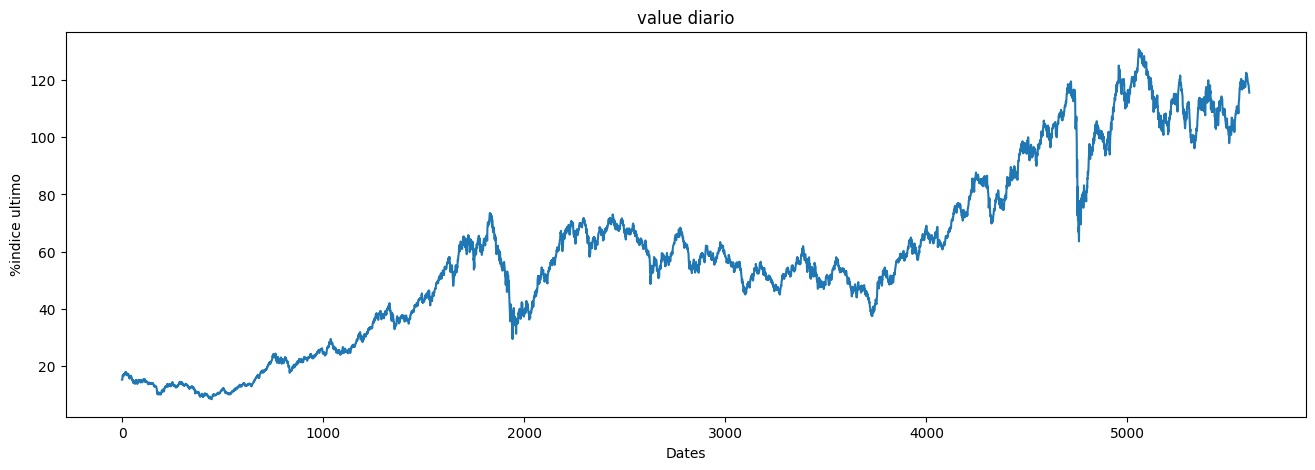

In [ ]:
ax=data['value'].plot(figsize=(16,5), title = "value diario")
ax.set(xlabel='Dates',ylabel='%indice ultimo')

## Exemplo de dados da Bovespa

In [ ]:
data.head()

date  Último  Abertura  Máxima  Mínima     Vol.   Var%   value
0  2000-12-27  15.186    14.805  15.223  14.805  239,98M  2,65%  15.186
1  2000-12-28  15.259    15.188  15.269  15.132  324,26M  0,48%  15.259
2  2001-01-02  15.425    15.242  15.621  15.174  230,63M  1,09%  15.425
3  2001-01-03  16.599    15.425  16.599  15.251  381,20M  7,61%  16.599
4  2001-01-04  16.675    16.597  16.933  16.587  331,23M  0,46%  16.675

## Informações das colunas no dataset bovespa

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5607 entries, 0 to 5606
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      5607 non-null   object 
 1   Último    5607 non-null   float64
 2   Abertura  5607 non-null   float64
 3   Máxima    5607 non-null   float64
 4   Mínima    5607 non-null   float64
 5   Vol.      5606 non-null   object 
 6   Var%      5607 non-null   object 
 7   value     5607 non-null   float64
dtypes: float64(5), object(3)
memory usage: 350.6+ KB


# Preparando dados

### Convertendo para DateTime

In [ ]:
data['date'] = pd.to_datetime(data['date'])

### Removento ponto(.) dos dados da bovespa

In [ ]:
data.loc[:, 'value'] = data['value'].apply(change_float)
data.head()

date  Último  Abertura  Máxima  Mínima     Vol.   Var%    value
0 2000-12-27  15.186    14.805  15.223  14.805  239,98M  2,65%  15186.0
1 2000-12-28  15.259    15.188  15.269  15.132  324,26M  0,48%  15259.0
2 2001-01-02  15.425    15.242  15.621  15.174  230,63M  1,09%  15425.0
3 2001-01-03  16.599    15.425  16.599  15.251  381,20M  7,61%  16599.0
4 2001-01-04  16.675    16.597  16.933  16.587  331,23M  0,46%  16675.0

### Set data para df_bovespa

In [ ]:
df_bovespa = data.copy()

## Set index para DateTimIndex no dataset Bovespa

In [ ]:
df_bovespa = df_bovespa.set_index(['date'])
df_bovespa.head()

Último  Abertura  Máxima  Mínima     Vol.   Var%    value
date                                                                 
2000-12-27  15.186    14.805  15.223  14.805  239,98M  2,65%  15186.0
2000-12-28  15.259    15.188  15.269  15.132  324,26M  0,48%  15259.0
2001-01-02  15.425    15.242  15.621  15.174  230,63M  1,09%  15425.0
2001-01-03  16.599    15.425  16.599  15.251  381,20M  7,61%  16599.0
2001-01-04  16.675    16.597  16.933  16.587  331,23M  0,46%  16675.0

### Filtrando colunas

In [ ]:
df_bovespa = df_bovespa[['value']]
df_bovespa.head()

value
date               
2000-12-27  15186.0
2000-12-28  15259.0
2001-01-02  15425.0
2001-01-03  16599.0
2001-01-04  16675.0

# Modelo ETS

In [ ]:
sm.tsa.seasonal_decompose

<function statsmodels.tsa.seasonal.seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)>

# Media de pontos por dia/BOVESPA

Text(0, 0.5, 'Média de Pontos da Bolsa')

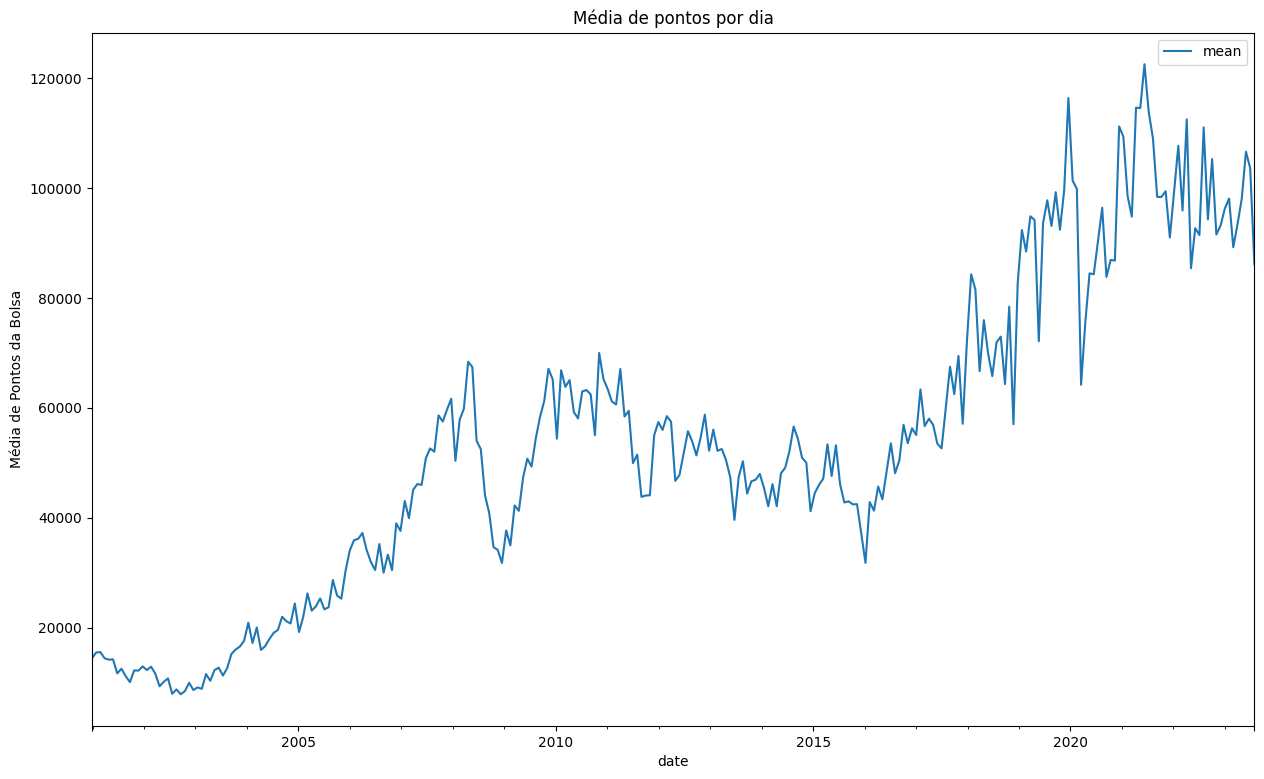

In [ ]:
df_bovespa["value"].resample("30D").apply([np.mean]).plot(figsize=(15, 9))
plt.title("Média de pontos por dia")
plt.ylabel("Média de Pontos da Bolsa")

# Agrupando dados da Bovespa

In [ ]:
df_groupby_bvp = df_bovespa.groupby('date')["value"].mean().reset_index()
df_groupby_bvp

date     value
0    2000-12-27   15186.0
1    2000-12-28   15259.0
2    2001-01-02   15425.0
3    2001-01-03   16599.0
4    2001-01-04   16675.0
...         ...       ...
5602 2023-08-10   11835.0
5603 2023-08-11  118065.0
5604 2023-08-14   11681.0
5605 2023-08-15  116171.0
5606 2023-08-16  115592.0

[5607 rows x 2 columns]

Text(0.5, 0, 'Mês')

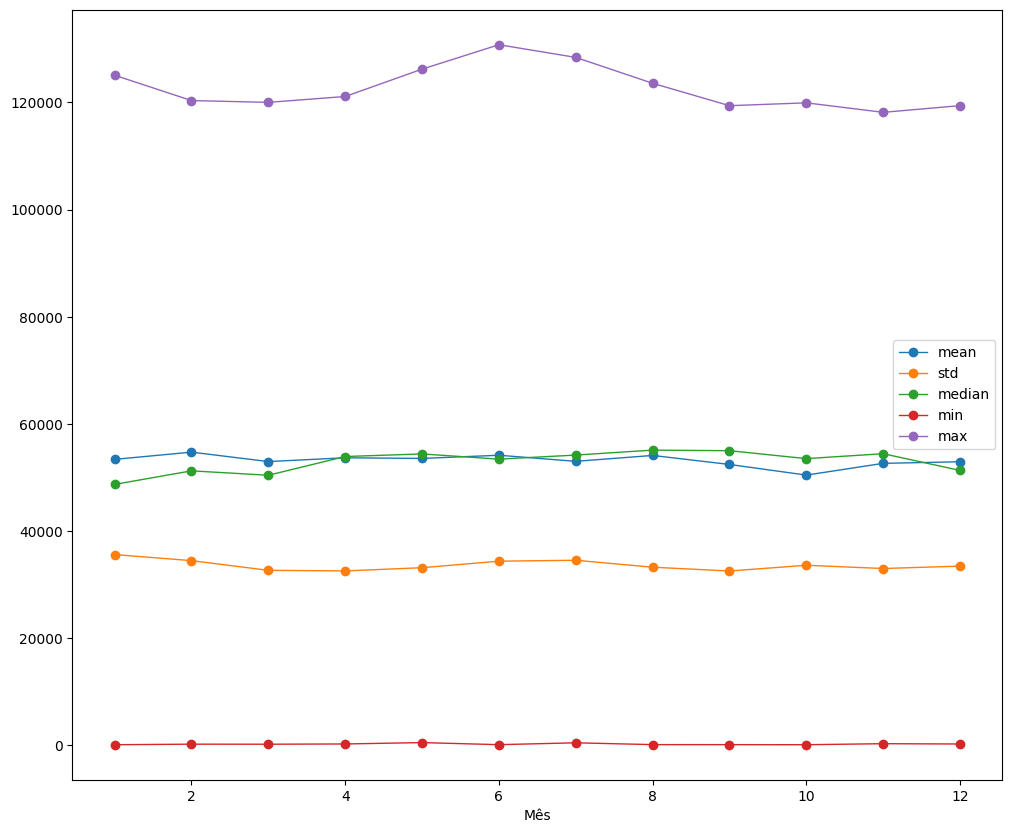

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
(df_groupby_bvp.set_index('date')
   .assign(month=lambda df: df.index.month)
   .groupby('month')['value'].agg(["mean", "std", "median", "min", "max"])
   .plot(ax=ax, marker="o",linewidth=1))
ax.set_xlabel('Mês')

## Modelo

In [ ]:
df_bovespa_ets = df_bovespa["value"].resample("30D").apply([np.mean])

In [ ]:
result_mult = sd(df_bovespa_ets, model='multiplicative')

In [ ]:
result_add = sd(df_bovespa_ets, model='additive')

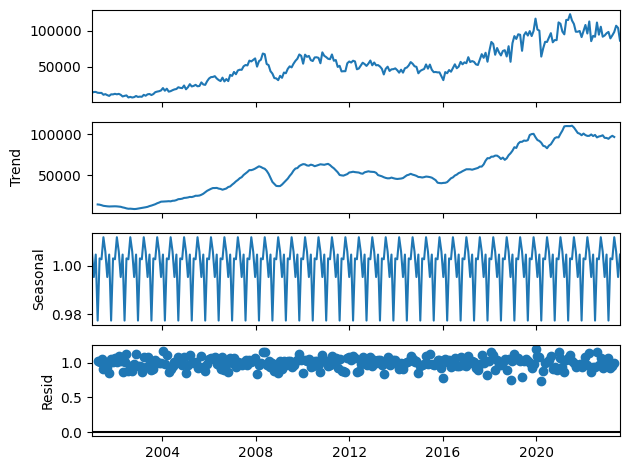

In [ ]:
plot_multi_ets = result_mult.plot()

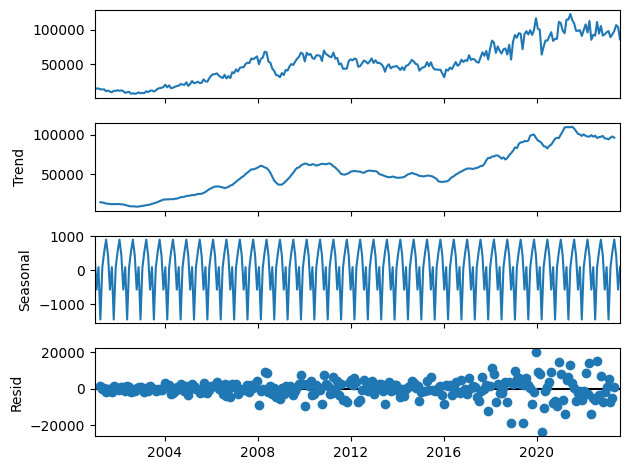

In [ ]:
plot_add_ets = result_add.plot()

In [ ]:
es_fit_add = ExponentialSmoothing(df_bovespa_ets, seasonal_periods=12, trend='additive', seasonal='additive').fit()

In [ ]:
es_fit_multi = ExponentialSmoothing(df_bovespa_ets, seasonal_periods=12, trend='multiplicative', seasonal='additive').fit()

<Axes: xlabel='date'>

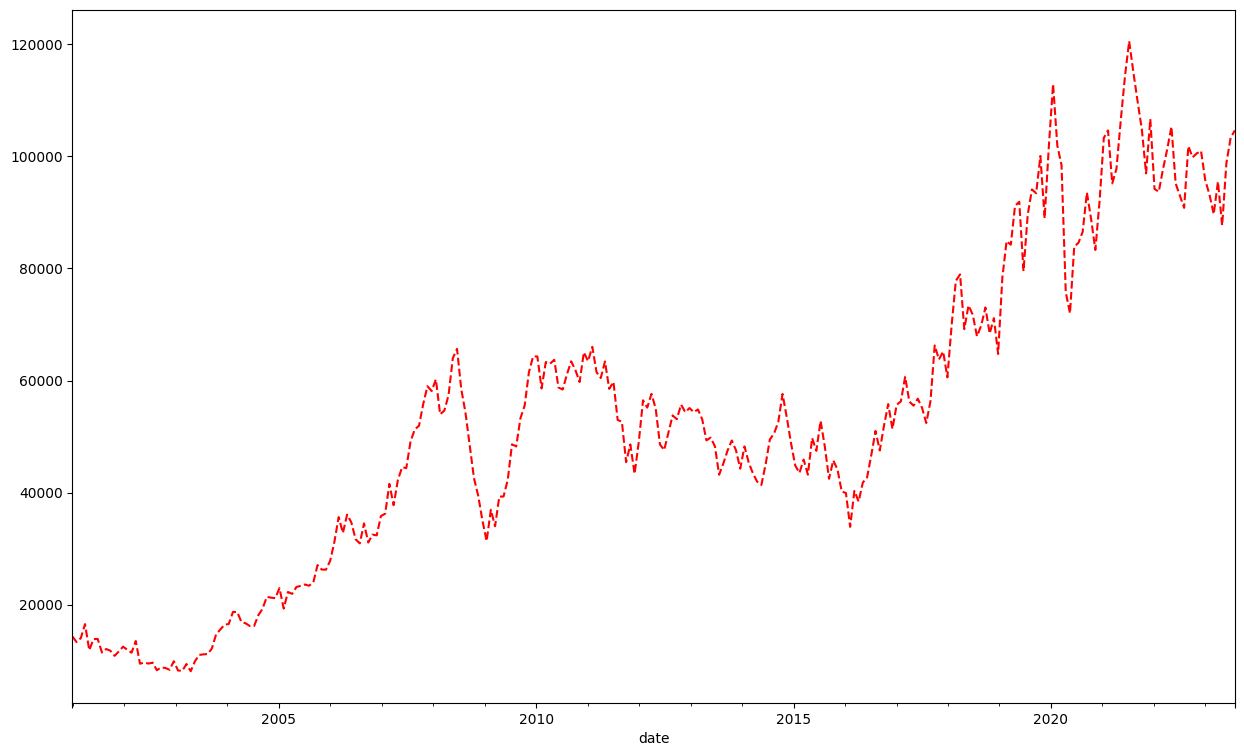

In [ ]:
es_fit_add.fittedvalues.plot(style='--', color='red', figsize=(15, 9))

<Axes: >

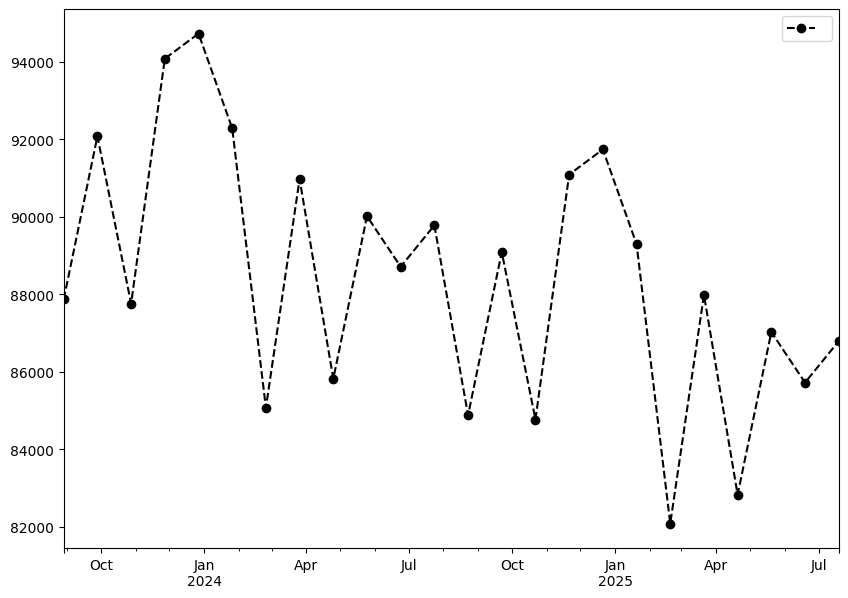

In [ ]:
es_fit_add.forecast(24).plot(style='--', marker='o', color='black', legend=True, figsize=(10, 7))


<Axes: >

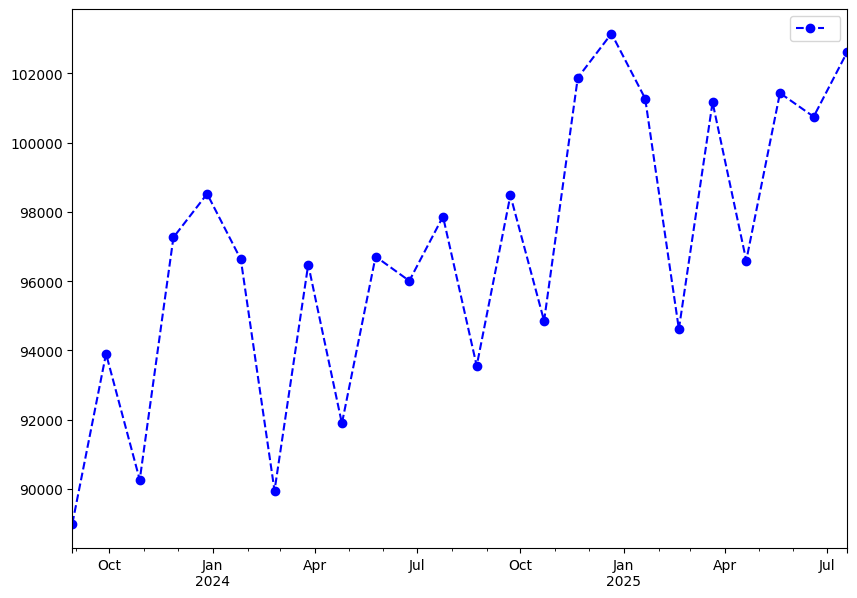

In [ ]:
es_fit_multi.forecast(24).plot(style='--', marker='o', color='blue', legend=True, figsize=(10, 7))

In [ ]:
print("MODELO ETS - Aditivo")
print(es_fit_add.forecast(13))
print ("\n")
print("MODELO ETS - Multiplicativo")
print(es_fit_multi.forecast(13))

MODELO ETS - Aditivo
2023-08-29    87868.929805
2023-09-28    92077.318258
2023-10-28    87758.168950
2023-11-27    94078.467289
2023-12-27    94727.034633
2024-01-26    92284.410533
2024-02-25    85072.587096
2024-03-26    90973.440679
2024-04-25    85819.071263
2024-05-25    90014.999323
2024-06-24    88710.516826
2024-07-24    89779.674217
2024-08-23    84879.461802
Freq: 30D, dtype: float64


MODELO ETS - Multiplicativo
2023-08-29    88995.216837
2023-09-28    93900.969528
2023-10-28    90257.981226
2023-11-27    97263.766653
2023-12-27    98521.844868
2024-01-26    96626.047453
2024-02-25    89946.713008
2024-03-26    96479.402515
2024-04-25    91889.537004
2024-05-25    96710.822886
2024-06-24    96008.034128
2024-07-24    97866.437303
2024-08-23    93552.551812
Freq: 30D, dtype: float64


# SARIMA

In [ ]:
df_bovespa_sarima = df_bovespa["value"].resample("30D").apply([np.mean])

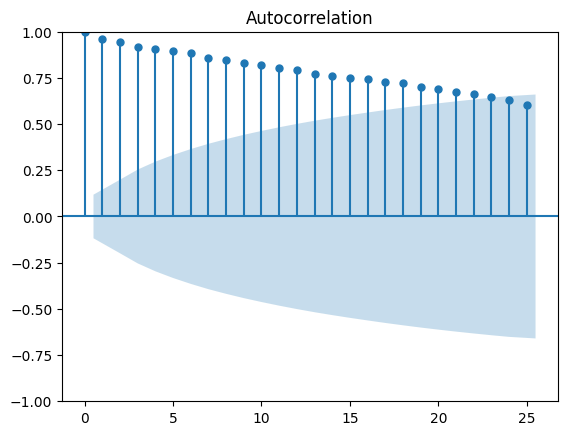

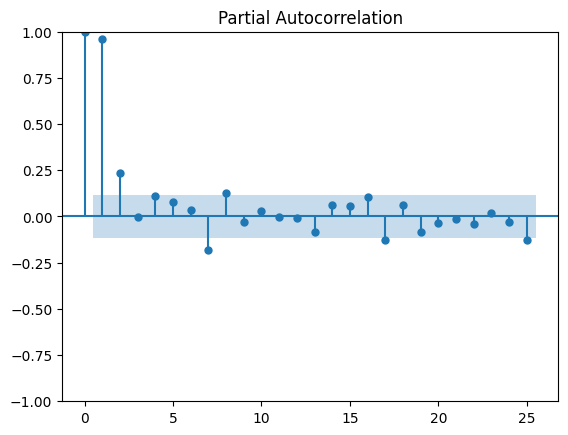

In [ ]:
plot_acf(df_bovespa_sarima)
plot_pacf(df_bovespa_sarima)
plt.show()

In [ ]:
mean = df_bovespa_sarima['mean']

In [ ]:
def adf_test(mean):
    # perform Augmented Dickey Fuller test
    print('Resutaldo do Teste Dickey-Fuller:')
    dftest = adfuller(mean, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Teste', 'Valor p', '# de lags', '# de observações'])
    for key, value in dftest[4].items():
        dfoutput['Valores Críticos ({})'.format(key)] = value
    print(dfoutput)

## AdFuller - Média

In [ ]:
adf_test(mean)

Resutaldo do Teste Dickey-Fuller:
Teste                      -1.074002
Valor p                     0.725328
# de lags                   7.000000
# de observações          268.000000
Valores Críticos (1%)      -3.454988
Valores Críticos (5%)      -2.872386
Valores Críticos (10%)     -2.572549
dtype: float64


## Media DIFF

In [ ]:
mean_diff = np.diff(mean)

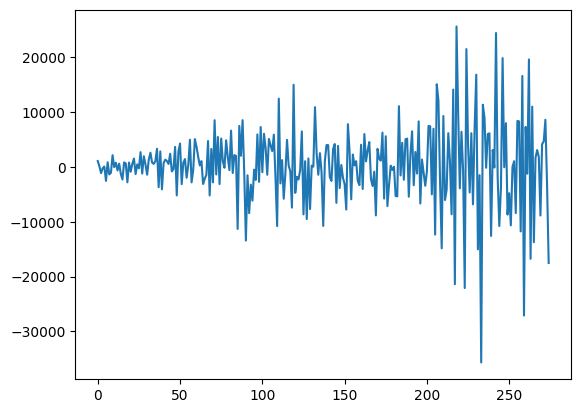

In [ ]:
plt.plot(mean_diff)

In [ ]:
adf_test(mean_diff)

Resutaldo do Teste Dickey-Fuller:
Teste                    -7.498893e+00
Valor p                   4.305834e-11
# de lags                 6.000000e+00
# de observações          2.680000e+02
Valores Críticos (1%)    -3.454988e+00
Valores Críticos (5%)    -2.872386e+00
Valores Críticos (10%)   -2.572549e+00
dtype: float64


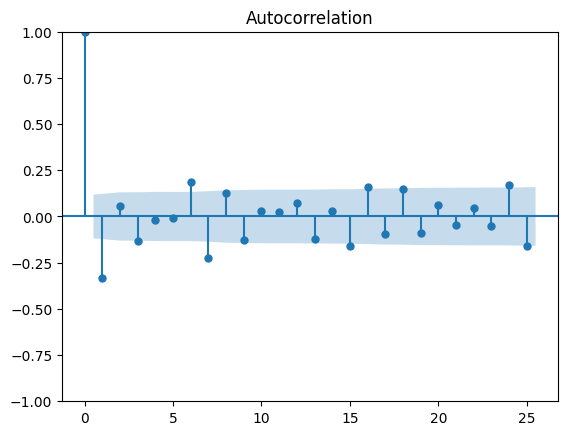

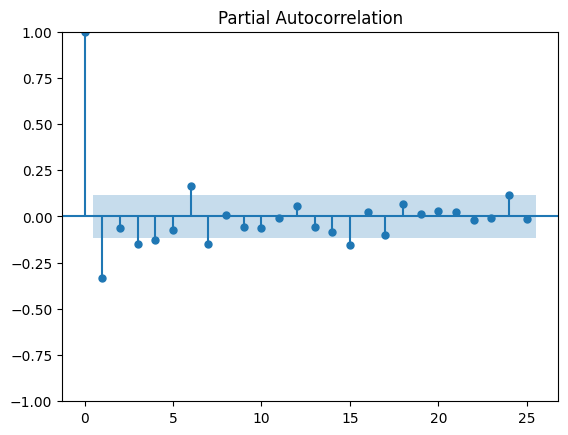

In [ ]:
plot_acf(mean_diff)
plot_pacf(mean_diff)
plt.show()

In [ ]:
sarimax_model = SARIMAX(df_bovespa, seasonal_order=(1,1,1,12)).fit()
print(sarimax_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                 5607
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood              -63751.923
Date:                              Mon, 04 Sep 2023   AIC                         127511.846
Time:                                      13:45:25   BIC                         127538.365
Sample:                                           0   HQIC                        127521.088
                                             - 5607                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1016      0.017      5.986      0.000       0.068       0.135
ar.S.L12       0.00

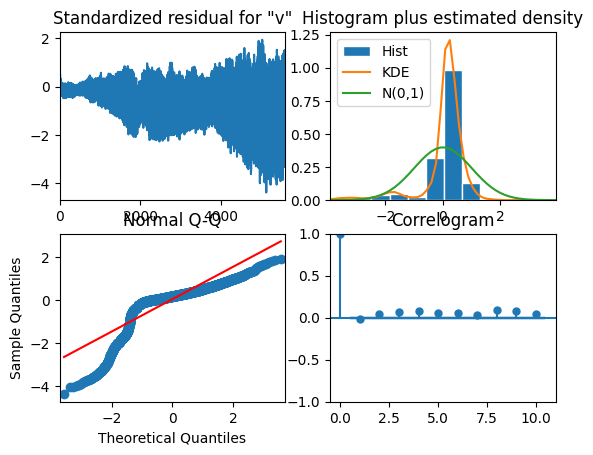

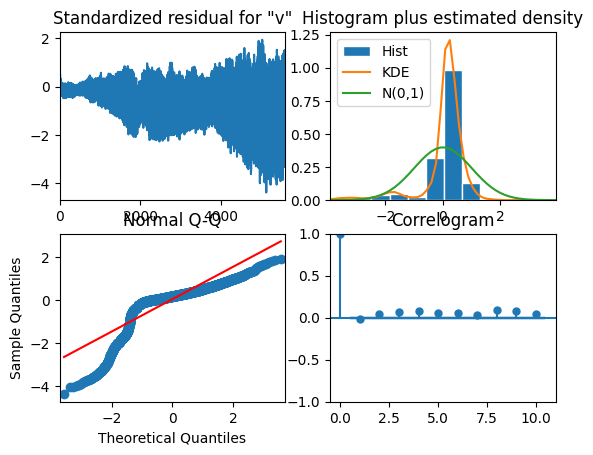

In [ ]:
sarimax_model.plot_diagnostics()

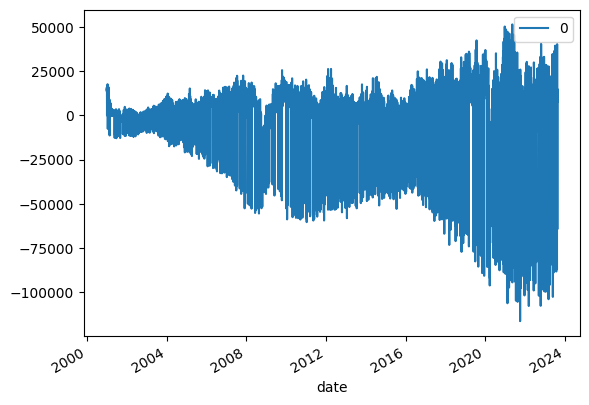

In [ ]:
residuals = DataFrame(sarimax_model.resid)
residuals.plot()
plt.show()

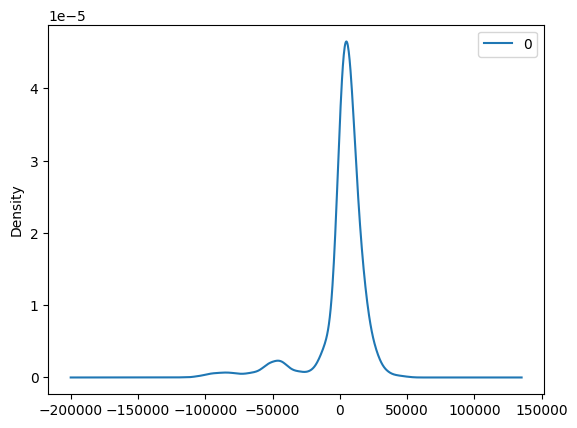

                   0
count    5607.000000
mean     1416.432559
std     20074.643918
min   -116273.392450
25%       261.931898
50%      5080.911877
75%     10451.770091
max     51324.028040


In [ ]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())


# Previsão Automatizada com o Sarimax

In [ ]:
stepwise_model = auto_arima(df_bovespa, start_p=1, start_q=1,max_p=3, max_q=3, m=7, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True, n_fits=20)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=9.65 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=133868.491, Time=0.19 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=130943.904, Time=1.79 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=9.80 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=132409.211, Time=0.36 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=130452.715, Time=5.15 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=16.37 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=6.53 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=131493.007, Time=2.52 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=129782.045, Time=5.51 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=130269.204, Time=3.32 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=19.47 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=10.52 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=129398.759, Time=8.03 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=12

In [ ]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5607
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -64693.380
Date:                           Mon, 04 Sep 2023   AIC                         129398.759
Time:                                   13:49:00   BIC                         129438.542
Sample:                                        0   HQIC                        129412.623
                                          - 5607                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7325      0.013    -55.465      0.000      -0.758      -0.707
ar.L2         -0.5012      0.015    -32.524      0.000      -0.531      -0.471
ar.L3         -0.2606      0.013    -19.477      0.000      -0.287      -0.234
ar.S.L7       -0.6887      0.013    -51.425      0.000      -0.715      -0.662
ar.S.L14      -0.3427      0.013    -27.014      0.000      -0.368      -0.318
sigma2      8.989e+08   6.93e-13    1.3e+21      0.000    8.99e+08    8.99e+08
===================================================================================
Ljung-Box (L1) (Q):                  12.97   Jarque-Bera (JB):             11038.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.17   Skew:                            -1.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [ ]:
print(stepwise_model.aic())

129398.75945499426


In [ ]:
future_forecast = stepwise_model.predict(n_periods=5)

In [ ]:
print(future_forecast)

5607     84791.588109
5608    114861.598051
5609    110519.711355
5610    142776.867142
5611     97374.070231
dtype: float64


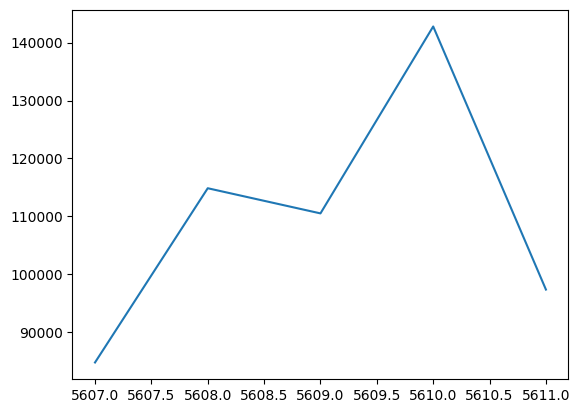

In [ ]:
plt.plot(future_forecast)

In [ ]:
future_forecast = DataFrame(future_forecast, columns=["mean"])

In [ ]:
pd.concat([future_forecast],axis=1)

mean
5607   84791.588109
5608  114861.598051
5609  110519.711355
5610  142776.867142
5611   97374.070231

<Axes: >

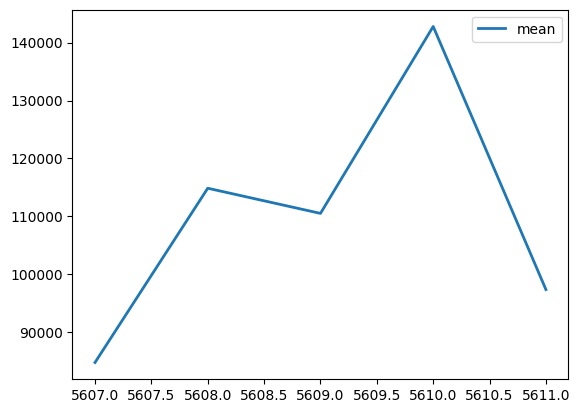

In [ ]:
pd.concat([future_forecast],axis=1).plot(linewidth=2)

# Prophet

In [ ]:
df_prophet = df_bovespa.copy()
df_prophet.reset_index(inplace=True)
df_prophet.rename(columns={'date': 'ds', 'value': 'y'}, inplace=True)

In [ ]:
# Split the dataset into a training and testing set
train_size = int(len(df_prophet) * 0.8)
train_df = df_prophet[:train_size]
test_df = df_prophet[train_size:]

In [ ]:
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(df_prophet)
future = prophet_model.make_future_dataframe(periods=5, freq='D')
future.tail()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk7dvo6_1/__4iesan.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk7dvo6_1/ifnb94fk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89089', 'data', 'file=/tmp/tmpk7dvo6_1/__4iesan.json', 'init=/tmp/tmpk7dvo6_1/ifnb94fk.json', 'output', 'file=/tmp/tmpk7dvo6_1/prophet_modely6o_0r6o/prophet_model-20230904145542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:55:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:55:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds
5607 2023-08-17
5608 2023-08-18
5609 2023-08-19
5610 2023-08-20
5611 2023-08-21

In [ ]:
forecast = prophet_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds           yhat    yhat_lower     yhat_upper
5607 2023-08-17  107722.642079  80544.752969  133175.612259
5608 2023-08-18  107067.414163  82657.095819  132362.701881
5609 2023-08-19  108088.112392  81666.292699  131467.187451
5610 2023-08-20  108211.558771  82773.256044  133218.141079
5611 2023-08-21  106462.347701  82144.581714  133065.151962

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly


#Plot the forecast
fig1 = plot_plotly(prophet_model, forecast)
fig1.show()

# Plot the forecast components
fig2 = plot_components_plotly(prophet_model, forecast)
fig2.show()
fig1 = plot_plotly(prophet_model, forecast)
fig1.show()

# Plot the forecast components
fig2 = plot_components_plotly(prophet_model, forecast)
fig2.show()

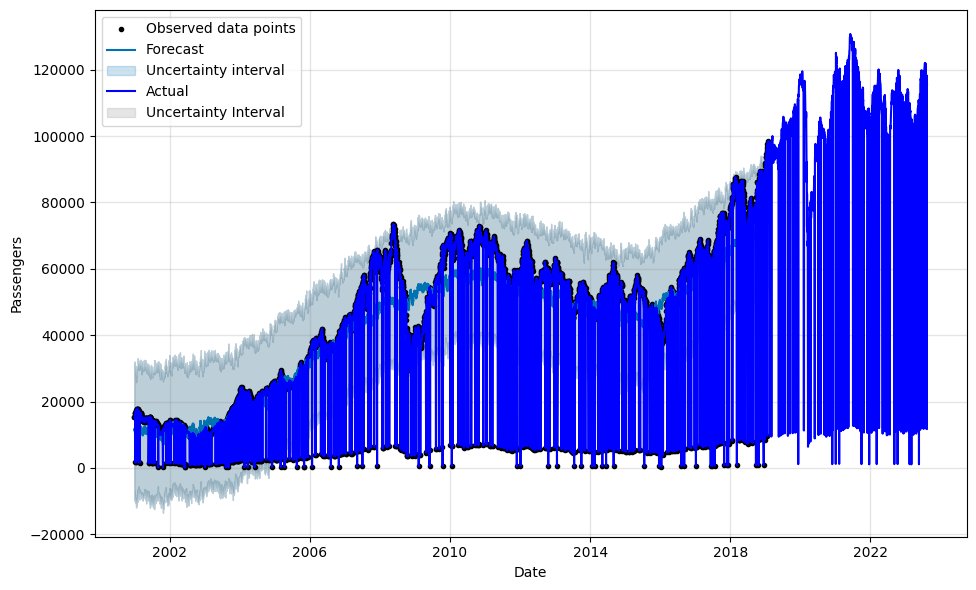

In [ ]:
# Plot the forecast
fig = prophet_model.plot(forecast, xlabel='Date', ylabel='Passengers')

# Add the actual values to the plot
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual', color='blue')

# Add the uncertainty intervals to the plot
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Uncertainty Interval')

# Show the plot
plt.legend()
plt.show()

In [ ]:
from prophet.diagnostics import cross_validation


In [ ]:
df_cv = cross_validation(prophet_model, initial='5607 days', period='5 days', horizon = '5 days')

INFO:prophet:Making 533 forecasts with cutoffs between 2016-04-29 00:00:00 and 2023-08-11 00:00:00


  0%|          | 0/533 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpk7dvo6_1/mo01ivr5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk7dvo6_1/ma91fzga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14059', 'data', 'file=/tmp/tmpk7dvo6_1/mo01ivr5.json', 'init=/tmp/tmpk7dvo6_1/ma91fzga.json', 'output', 'file=/tmp/tmpk7dvo6_1/prophet_modelf084n_xx/prophet_model-20230904140427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:04:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:04:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk7dvo6_1/psf964_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk7dvo6_1/xop8e6tq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_cv.head()

ds          yhat    yhat_lower    yhat_upper        y     cutoff
0 2016-05-02  42341.103598  24404.378780  58623.704751  53562.0 2016-04-29
1 2016-05-03  42790.084438  25810.294902  60995.385408   5226.0 2016-04-29
2 2016-05-04  42726.191237  25002.661687  60646.698005  52553.0 2016-04-29
3 2016-05-05  43041.703137  24773.844482  60997.558679  51671.0 2016-05-04
4 2016-05-06  42946.517384  25477.024376  59940.056315  51718.0 2016-05-04

In [ ]:
df_cv[df_cv['ds'] >= '2023-08-10'].head()

ds           yhat    yhat_lower     yhat_upper         y  \
1806 2023-08-10  109983.041787  85951.222813  134891.823907   11835.0   
1807 2023-08-11  109135.028792  84369.947003  134335.950476  118065.0   
1808 2023-08-14  106470.799217  81605.299087  132157.529312   11681.0   
1809 2023-08-15  106951.962101  82210.231481  132680.320928  116171.0   
1810 2023-08-16  108055.190359  81802.129800  132885.632036  115592.0   

         cutoff  
1806 2023-08-06  
1807 2023-08-06  
1808 2023-08-11  
1809 2023-08-11  
1810 2023-08-11

In [ ]:
from prophet.diagnostics import performance_metrics


In [ ]:
# Compute performance metrics
df_metrics = performance_metrics(df_cv)
df_metrics['mape'].mean()

2.093777410237418